# ECE 276C HW3 P1
Mingwei Xu A53270271

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import Categorical

## Define Network

In [2]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0]
        self.action_space_n = env.action_space.n

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 48)
        self.l2 = nn.Linear(48, self.action_space_n)

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Softmax(dim=-1),
            self.l2,
            nn.Softmax(dim=-1))

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [3]:
def choose_action(policy_network, state):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :returns: int, action; tensor, log probability
    """
    probs = policy_network.forward(state)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action.item(), log_prob

## Setup CUDA

In [4]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cuda
GeForce GTX 1080


## Question 1.1

In [5]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_sum = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_sum += log_prob

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                traj_discounted_return = torch.sum(torch.FloatTensor(traj_rewards).to(device) *
                                                   torch.FloatTensor([gamma ** t for t in range(1, len(traj_rewards) + 1)]).to(device))  # G(t)
                batch_loss_sum += traj_discounted_return * traj_log_prob_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_sum = 0

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [6]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99)

Episode [1/200] loss: 403.32, average reward: 21.74, trajectory num: 23
Episode [2/200] loss: 259.78, average reward: 19.23, trajectory num: 26
Episode [3/200] loss: 353.57, average reward: 21.74, trajectory num: 23
Episode [4/200] loss: 280.00, average reward: 20.00, trajectory num: 25
Episode [5/200] loss: 281.03, average reward: 19.23, trajectory num: 26
Episode [6/200] loss: 286.45, average reward: 19.23, trajectory num: 26
Episode [7/200] loss: 332.71, average reward: 20.00, trajectory num: 25
Episode [8/200] loss: 310.19, average reward: 20.83, trajectory num: 24
Episode [9/200] loss: 549.01, average reward: 27.78, trajectory num: 18
Episode [10/200] loss: 392.10, average reward: 22.73, trajectory num: 22
Episode [11/200] loss: 438.20, average reward: 25.00, trajectory num: 20
Episode [12/200] loss: 317.45, average reward: 20.83, trajectory num: 24
Episode [13/200] loss: 459.93, average reward: 23.81, trajectory num: 21
Episode [14/200] loss: 377.45, average reward: 21.74, trajec

### Plot

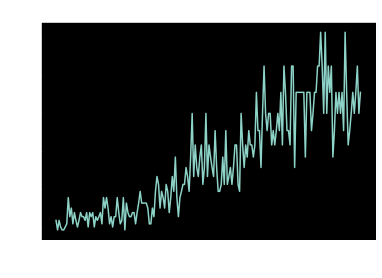

In [7]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('episode')
plt.ylabel('average reward')
plt.title('Question 1.1 Average Rewards at Each Iteration')
plt.savefig('Question_1-1.png')
plt.show()

## Question 1.2

In [55]:
def reinforce_modified(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using modified reinforce method that only counts on future rewards

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_loss_sum = 0
        traj_rewards = []
        traj_log_prob_list = []

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                # discounted_return_list = []
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(len(traj_rewards))]) \
                                          for t in range(len(traj_rewards))]
                # for t in range(len(traj_rewards)):
                #     discounted_return_sum = sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(len(traj_rewards))])
                #     discounted_return_list.append(discounted_return_sum)

                # sum the traj loss by loop so we do not lose tensor gradient
                traj_loss_sum = 0
                for t in range(len(traj_log_prob_list)):
                    traj_loss_sum += traj_log_prob_list[t] * discounted_return_list[t]
                batch_loss_sum += traj_loss_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_loss_sum = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [56]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce_modified(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99)

Episode [1/200] loss: 471.89, average reward: 21.74, trajectory num: 23
Episode [2/200] loss: 546.80, average reward: 22.73, trajectory num: 22
Episode [3/200] loss: 364.51, average reward: 20.83, trajectory num: 24
Episode [4/200] loss: 303.35, average reward: 18.52, trajectory num: 27
Episode [5/200] loss: 643.51, average reward: 26.32, trajectory num: 19
Episode [6/200] loss: 392.20, average reward: 21.74, trajectory num: 23
Episode [7/200] loss: 292.09, average reward: 18.52, trajectory num: 27
Episode [8/200] loss: 360.59, average reward: 20.00, trajectory num: 25
Episode [9/200] loss: 593.20, average reward: 23.81, trajectory num: 21
Episode [10/200] loss: 384.14, average reward: 20.83, trajectory num: 24
Episode [11/200] loss: 252.36, average reward: 17.86, trajectory num: 28
Episode [12/200] loss: 342.00, average reward: 20.00, trajectory num: 25
Episode [13/200] loss: 750.93, average reward: 27.78, trajectory num: 18
Episode [14/200] loss: 471.55, average reward: 23.81, trajec

### Plot

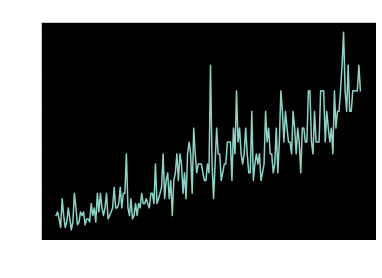

In [57]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('episode')
plt.ylabel('average reward')
plt.title('Question 1.2 Average Rewards at Each Iteration')
plt.savefig('Question_1-2.png')
plt.show()